# Homework 4: Sequence Models

## Task 0: Dataset and Analysis
In your project, you will pick a dataset (time-series) and an associated problem that can be
solved via sequence models. You must describe why you need sequence models to solve this
problem. Include a link to the dataset source. Next, you should pick an RNN framework that you
would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other
Python Package)

### Dataset and Framework Selection
For my dataset I have selected the time series occupancy detection binary classification task dataset from [https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). This dataset contains a time series with data from various sensors such as temperature, humidity, light, CO2, and HumidityRatio, with the goal of predicting if the room is occupied or not. For our framework we select to use Pytorch.

### Dataset Analysis

In [143]:
import pandas as pd

#The data has already been separated into train, test, we split test into validation and test for even class distribution
train_data = pd.read_csv("data/datatraining.txt")
pd.read_csv("data/datatest.txt")
test_data_base = pd.read_csv("data/datatest2.txt")
split_row = 4500
test_data = test_data_base.iloc[:split_row, :]
validation_data = test_data_base.iloc[split_row:, :]
validation_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
4501,2015-02-14 17:48:00,19.89,35.5,0.0,519.000000,0.005103,0
4502,2015-02-14 17:49:00,19.89,35.5,0.0,516.666667,0.005103,0
4503,2015-02-14 17:50:00,19.89,35.5,0.0,516.000000,0.005103,0
4504,2015-02-14 17:51:00,19.89,35.5,0.0,515.000000,0.005103,0
4505,2015-02-14 17:51:59,19.89,35.5,0.0,516.500000,0.005103,0


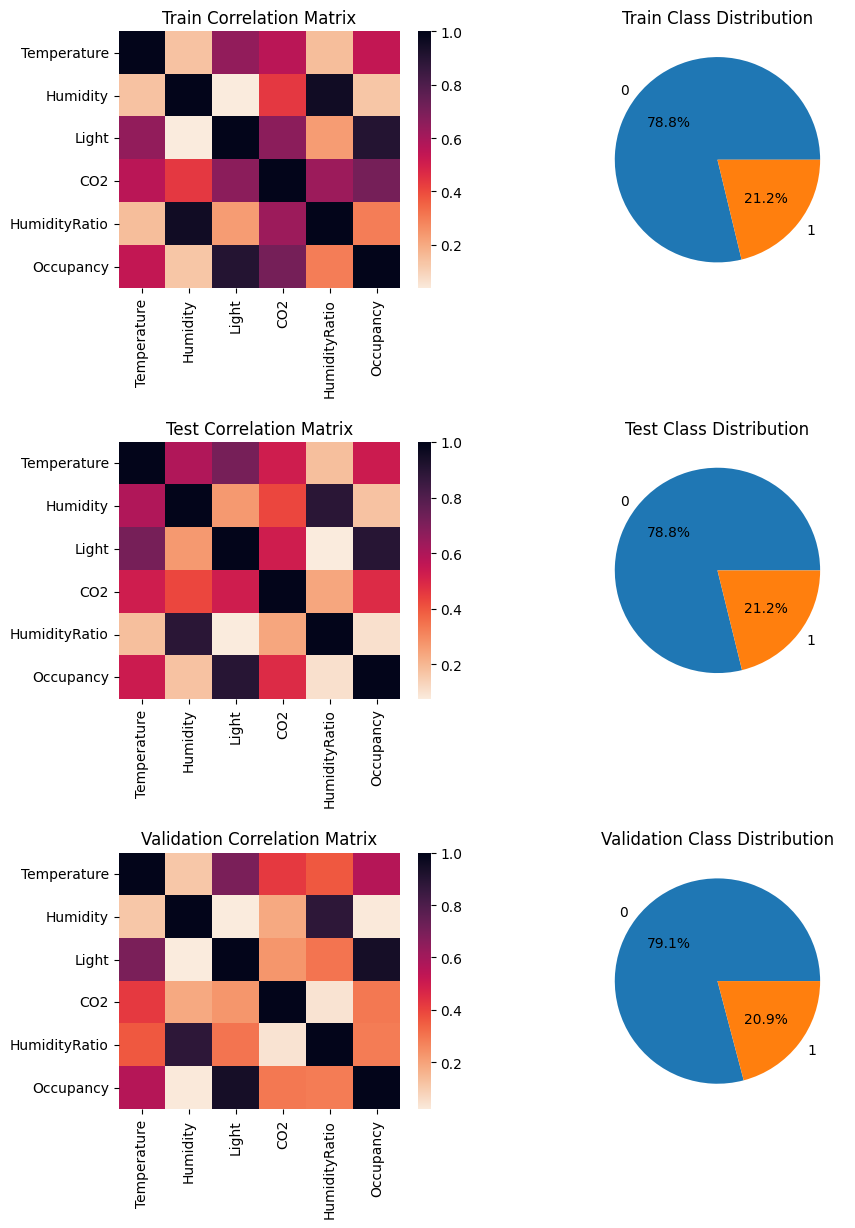

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heat_and_pie(name, data, axis, axis_index):
    axis[axis_index, 0].set_title(name + " Correlation Matrix")
    sns.heatmap(data.corr().abs(),annot=False, ax=ax[axis_index, 0], cmap='rocket_r')
    axis[axis_index, 1].set_title(name + " Class Distribution")
    axis[axis_index, 1].pie(x=data["Occupancy"].value_counts(), labels=data["Occupancy"].value_counts().index, autopct='%1.1f%%')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,14))
fig.subplots_adjust(hspace=0.6)
plot_heat_and_pie("Train", train_data, ax, 0)
plot_heat_and_pie("Test", test_data, ax, 1)
plot_heat_and_pie("Validation", validation_data, ax, 2)


The class imbalance of occupancy in the test set is likely due to this being real world time series with respect to humans in the room and you can't just add more instances of humans in the room during a time period without redoing the whole dataset, the way you could with a real dataset. We see that at least correlation-wise in the training and test sets, the predictors change. 
Due to the large class imbalance and potentially negative consequences of false negatives, we will use F1 score as our metric for evaluation.

Finally we plot the normalized values of our features as lines and show the occupancy in the background (green for occupied, red for unoccupied), this visualization helps us greatly understand the nature of the dataset

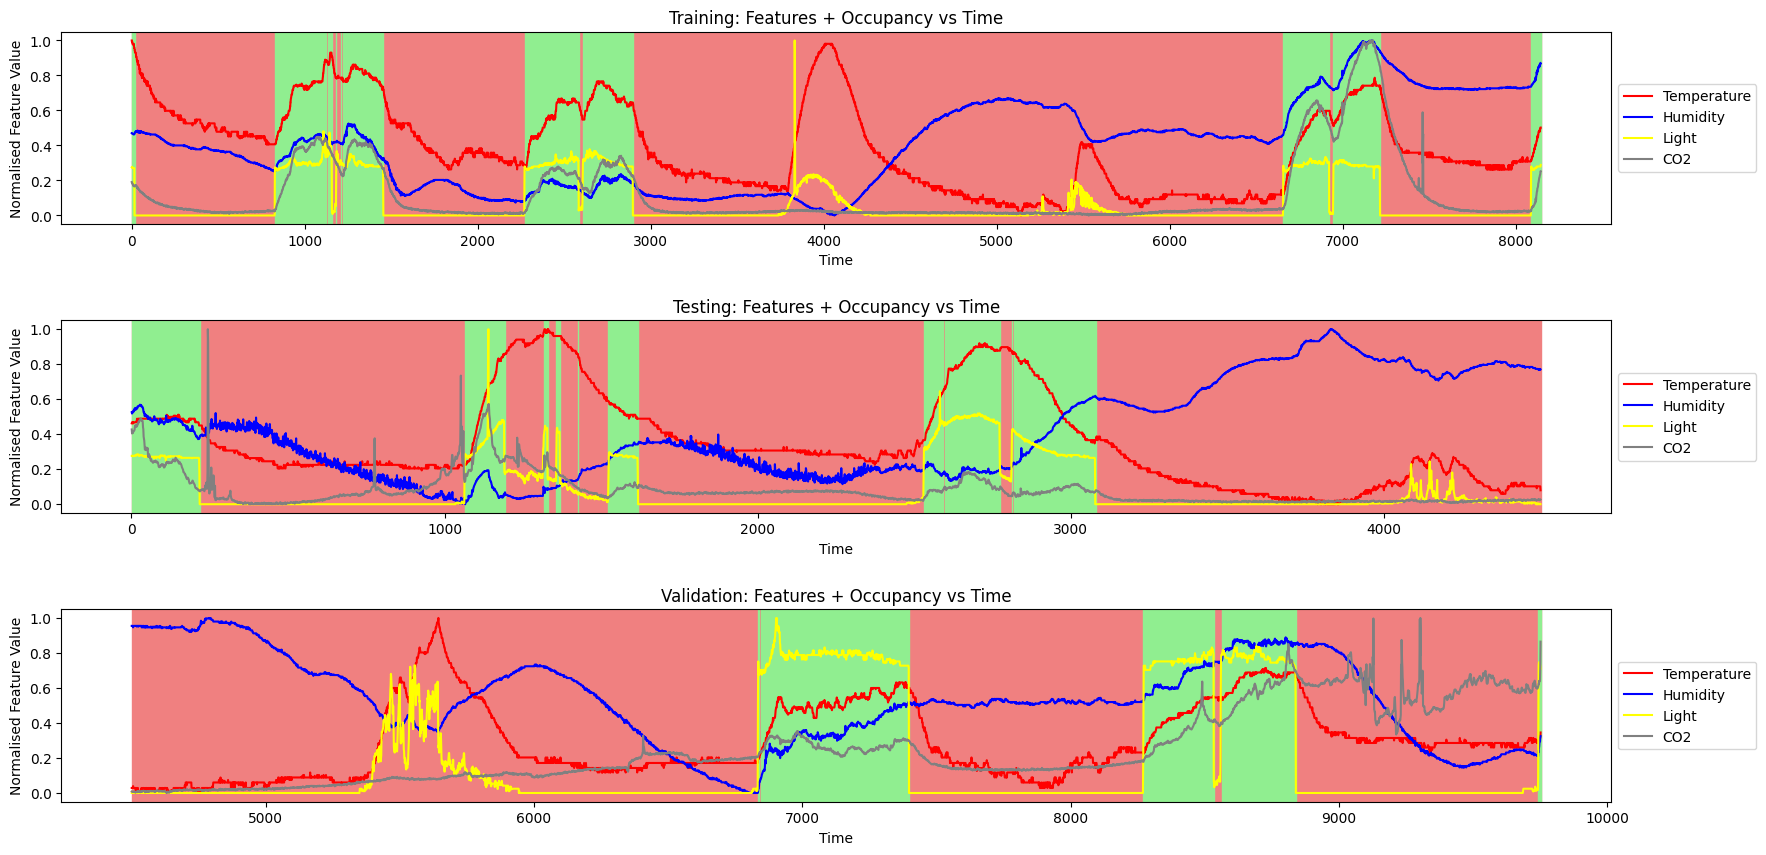

In [148]:
import numpy as np

def normalize_plot(data, label, color, axis):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    axis.plot(data, label=label, color=color)

def plot_data(name, data_frame, axis):
    #Algo for collecting when room is occupied spans for fast drawing
    occupancyFlag = 0
    occupancySpans = []
    for row in data_frame.iterrows(): 
        occupancyStatus = row[1]["Occupancy"]
        index = row[0]
        if occupancyFlag == 0 and occupancyStatus == 1:
            occupancyFlag = 1
            occupancySpans.append([index, None])
        elif occupancyFlag == 1 and occupancyStatus == 0:
            occupancyFlag = 0
            occupancySpans[-1][1] = index
    if occupancyFlag == 1:
        occupancySpans[-1][1] = index
    start = data_frame.head(1).index[0]
    axis.axvspan(start, start + len(data_frame), color= "lightcoral") 
    for start, end in occupancySpans:
        axis.axvspan(start, end, color="lightgreen")

    normalize_plot(data_frame["Temperature"], "Temperature", "red", axis)
    normalize_plot(data_frame["Humidity"], "Humidity", "blue", axis)
    normalize_plot(data_frame["Light"], "Light", "yellow", axis)
    normalize_plot(data_frame["CO2"], "CO2", "grey", axis)
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axis.set_title(name + ": Features + Occupancy vs Time")
    axis.set_ylabel("Normalised Feature Value")
    axis.set_xlabel("Time")

fig, axs = plt.subplots(nrows=3, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)
plot_data("Training", train_data, axs[0])
plot_data("Testing", test_data, axs[1])
plot_data("Validation", validation_data, axs[2])


The fractured nature of these datasets of time periods where someone is in the room then out of it and the imbalance in the class distribution temporally will play an issue later when we evaluate the model with respect to F-Score, as we will see the model is better than it should be at evaluating the easy looking validation data, but bad at the more difficult testing data.

### Pytorch Dataset Creation
We create a pytorch sequence dataset class for ourself that takes our time series data and returns elements with a sequence of n proceeding features for our label. This introduces a hyper parameter sequence_length, which is the size of the sequence we pass to our RNN layer in our network. We then construct a dataloader which batches our elements, the final shape of our network input is batch_size X sequence_length X num_features.

In [149]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

#Creating a custom time series dataset in pytorch
class OccupancyDataset(Dataset):
    def __init__(self, data_frame, sequence_length):
        self.data = data_frame.to_numpy()
        self.features = self.data[:, 1:-1]
        self.features = self.features.astype("float32")
        self.labels = self.data[:, -1]
        self.labels = self.labels.astype("float32")
        self.sequence_length = sequence_length
    
    #Since the first self.sequence_length elements don't have enough proceeding time series data, they can't be elements
    def __len__(self):
        return self.data.shape[0] - (self.sequence_length - 1)
    
    #returns sequence_length points from the index and uses the final feature's occupancy as its label
    def __getitem__(self, index):
        return (self.features[index:index+self.sequence_length, :], self.labels[index+self.sequence_length-1])


#Testing that our dataset returns the elements we want in the correct shape
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sample_training_dataset = OccupancyDataset(train_data, 10)
print("single X point shape: " + str(sample_training_dataset[0][0].shape)) #should be sequence_length X num_features
print("single point: " + str(sample_training_dataset[0]))

#We can safely shuffle a dataset created with this since it won't change the proceeding time series elements in the underlying data matrix
sample_training_dataloader = DataLoader(sample_training_dataset, batch_size= 64, shuffle=True)
sample_X, sample_y = next(iter(sample_training_dataloader))
print("X batch shape: " + str(sample_X.shape)) #should be batch_size X sequence_length X num_features


#Hyperparameter for representing how many features we have
num_features = 5


single X point shape: (10, 5)
single point: (array([[23.180, 27.272, 426.000, 721.250, 0.005],
       [23.150, 27.267, 429.500, 714.000, 0.005],
       [23.150, 27.245, 426.000, 713.500, 0.005],
       [23.150, 27.200, 426.000, 708.250, 0.005],
       [23.100, 27.200, 426.000, 704.500, 0.005],
       [23.100, 27.200, 419.000, 701.000, 0.005],
       [23.100, 27.200, 419.000, 701.667, 0.005],
       [23.100, 27.200, 419.000, 699.000, 0.005],
       [23.100, 27.200, 419.000, 689.333, 0.005],
       [23.075, 27.175, 419.000, 688.000, 0.005]], dtype=float32), 1.0)
X batch shape: torch.Size([64, 10, 5])


## Task 1: RNN implementation

### Part 1 (30 points)
Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).

### Hyper Parameters and Training Loop

For our optimizer we use Adam and for our loss function we choose Binary Cross entropy loss, which is considered one of the best for
picks for binary classification tasks, as a consequence of this selection, the final layer of our network will need to have sigmoid activation
as BCE expects ranges between 0 and 1. For our metric we choose to use F1 due to high class imbalance (1 to 5) and depending on the situation, "high costs" of false negatives (its annoying if the lights go off while you are in the room etc). 

In [160]:

import torch
from sklearn.metrics import f1_score, confusion_matrix

#Hyperparameters 

sequence_length = 50
batch_size = 256        #Convergence is very jittery with small batch sizes
epochs = 20
optimizer = torch.optim.Adam
lossFunction = torch.nn.BCELoss()

#setting up our datasets
train_dataset = OccupancyDataset(train_data, sequence_length)
valid_dataset = OccupancyDataset(validation_data, sequence_length)
test_dataset = OccupancyDataset(test_data, sequence_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


#get an entire dataset as a single tensor for F1 computation
def as_tensors(dataset):
    return next(iter(DataLoader(dataset, batch_size=len(dataset))))

#predict the binary classes from X when fed through the model
def predict(model, X):
    model_outputs = model(X)
    predicted_classes = torch.round(model_outputs) #Since this is a binary classification task
    return predicted_classes

def print_F1_dataset(name, model, X, y):
    y_prime = predict(model, X)
    f1 = f1_score(y, y_prime.detach().numpy())
    print("F1 Score for {}: {:0.2f}%".format(name, f1*100))

#Model main training loop, we'll use this for the RNN and reuse for LSTM + GRU task later
def train_and_evaluate(name, model):
    model_optimizer = optimizer(model.parameters())
    losses = []
    print("Epochs: ")
    for epoch in range(epochs):
        print(str(epoch) + ",", end="")
        for X, y in train_dataloader:
            model_outputs = model(X)
            batch_cost = lossFunction(model_outputs, y)
            losses.append(batch_cost)
            model_optimizer.zero_grad()
            batch_cost.backward()
            model_optimizer.step()
    print("\b\n")
    print_F1_dataset("Training", model, *as_tensors(train_dataset))
    print_F1_dataset("Validation", model, *as_tensors(valid_dataset))
    print_F1_dataset("Testing", model, *as_tensors(test_dataset))
    fig, ax = plt.subplots(nrows=2, figsize=(5,10)) 
    ax[0].set_title(name + " Loss vs Time")
    ax[0].set_xlabel("Loss")
    ax[0].set_ylabel("Time")
    ax[0].plot(losses)
    x_test, y_test = as_tensors(train_dataset)
    test_confusion_matrix = confusion_matrix(y_test, predict(model, x_test).detach().numpy())
    ax[1].set_title("Testing Confusion Matrix")
    sns.heatmap(test_confusion_matrix, ax=ax[1], annot=True, cmap='RdYlGn', fmt='d')

### RNN Implementation

for implementing my RNN I use PyTorch's RNN layer. The cell structure of the RNN layer in pytorch is similar to the cell structure we learned about in class with the output function: `h_t = tanh(W_xh * x_t + W_hh * h_(t-1))`. The pytorch cell adds in bias for the hidden state and the input giving us the output function `h_t = tanh(W_xh * x_t + b_x + W_hh * h_(t-1) + b_h)`. 
`tanh` is used as the activation function between cells in the RNN to squish hidden states between negative one and one which can help deal with exploding gradient as opposed to other activation functions such as ReLU. We have to flatten torch's RNN output since it comes out in `batch_size X sequence_length X hidden_state, this is known as "many to many" where each time step produces its own output. Counterintuitively while testing the hyperparameters I found it preforms better than many to one. after flattening we pass to a final linear layer with one node that preforms the binary classification. We use a sigmoid activation on this layer as this is what Binary Cross Entropy Loss is expecting, an output between 0 and 1. Pytorch RNNs can't be used in Sequence Models because torch RNN layers outputs a tuple containing the final hidden state which we want to discard, hence we must manually extract the one we want from the output tuple before feeing it into our final linear layer for prediction, by defining our own torch module.

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

F1 Score for Training: 87.21%
F1 Score for Validation: 90.50%
F1 Score for Testing: 87.32%


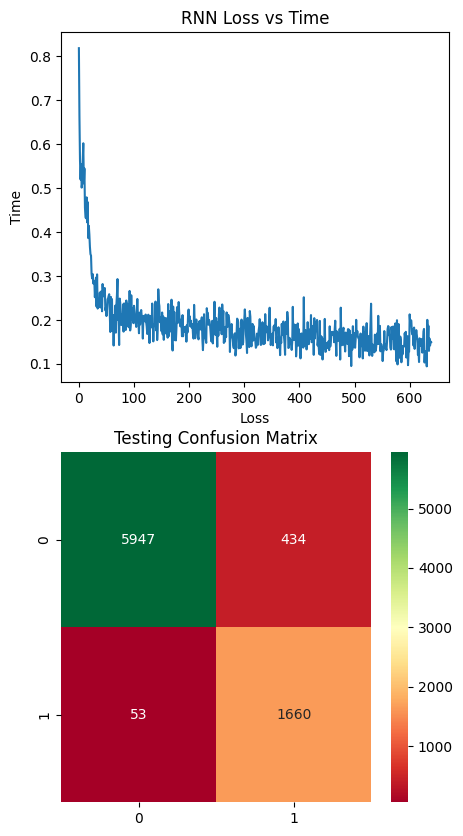

In [181]:

import torch.nn

#Hyperparameters
hidden_size = 10

class MyRNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #batch_first=True sets it so the order of input features is batch_size X sequence_length X num_features as we have prepared our dataset.
        self.rnn = torch.nn.RNN(input_size=num_features, hidden_size=hidden_size, batch_first=True)

        #rnn output shape is batch_size X sequence_length X hidden_size, 
        #we flatten this into batch_size X (sequence_length * hidden_size) so we can pass it to our final layer
        self.flatten = torch.nn.Flatten()

        #For our linear layer, we use the one node binary classification method rather than the two node one to avoid converting to/from onehots. 
        #There is debate over this on the internet but consensus seems to indicate this does not significantly impact performance  
        self.linear = torch.nn.Linear(in_features=sequence_length*hidden_size, out_features=1)

        #Sigmoid since we're using Binary Cross Entropy which expects inputs between 0 and 1 and this is a binary classification task 
        self.sigmoid = torch.nn.Sigmoid()

    #As long as the tensor passes through the layers, the weights will be added for the gradient backprop
    def forward(self, X):
        #discarding the hidden values           Input Shapes:
        rnn_out, _ = self.rnn(X)                #batch_size X sequence_length X num_features
        flatten_out = self.flatten(rnn_out)     #batch_size X sequence_length X hidden_size
        linear_out = self.linear(flatten_out)   #batch_size X (sequence_length * hidden_size)
        linear_out = torch.squeeze(linear_out)  #batch_size X 1
        sigmoid_out = self.sigmoid(linear_out)  #batch_size
        return sigmoid_out


my_RNN_model = MyRNN()
train_and_evaluate("RNN", my_RNN_model)

Interestingly we preform better half a percent better on the test data than the training data, presumably because due to the time series. 

### Part 2 (35 points): LSTM, GRU

Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?

### LSTM Implementation

I implement a pytorch LSTM model. The interface is just like the RNN, where we specify the number of features and the hidden size as well as specifying batch first. In terms of cell structure, the LSTM cell has 3 gates, the Input gate, the forget gate, and the output gate. The input gate decides what gets stored in the long term memory within the hidden state. The forget gate removes items in long term memory based on the short term memory and the the current input. Finally the output gate computes the new short term memory for the next cycle from the updated long term memory, the input, and the previous short term memory. This structure makes the LSTM a unique model for being able to "remember" patens in the past as opposed to raw RNNs which are basically all short term memory.   

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

F1 Score for Training: 96.42%
F1 Score for Validation: 95.55%
F1 Score for Testing: 90.77%


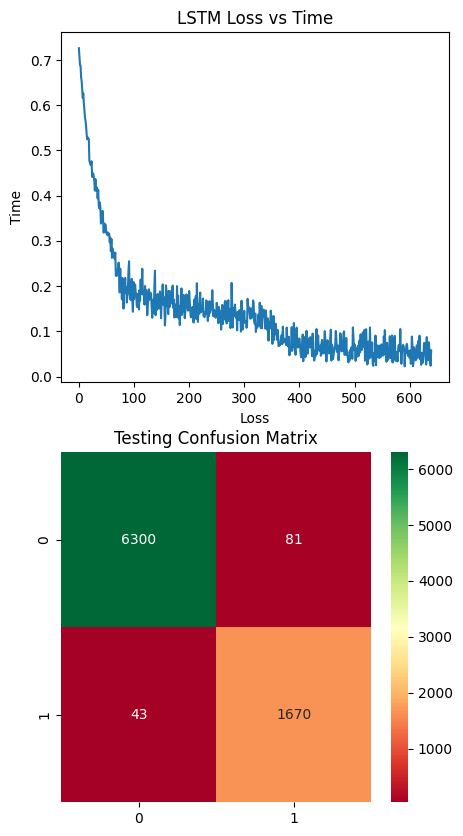

In [179]:
import torch.nn

#Hyperparameters
hidden_size = 10

class MyLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #batch_first=True sets it so the order of input features is batch_size X sequence_length X num_features as we have prepared our dataset.
        self.lstm = torch.nn.LSTM(input_size=num_features, hidden_size=hidden_size, batch_first=True)

        #lstm output shape is batch_size X sequence_length X hidden_size, 
        #we flatten this into batch_size X (sequence_length * hidden_size) so we can pass it to our final layer
        self.flatten = torch.nn.Flatten()

        #For our linear layer, we use the one node binary classification method rather than the two node one to avoid converting to/from onehots. 
        #There is debate over this on the internet but consensus seems to indicate this does not significantly impact performance  
        self.linear = torch.nn.Linear(in_features=sequence_length*hidden_size, out_features=1)

        #Sigmoid since we're using Binary Cross Entropy which expects inputs between 0 and 1 and this is a binary classification task 
        self.sigmoid = torch.nn.Sigmoid()

    #As long as the tensor passes through the layers, the weights will be added for the gradient backprop
    def forward(self, X):
        #discarding the hidden values           Input Shapes:
        lstm_out, _ = self.lstm(X)              #batch_size X sequence_length X num_features
        flatten_out = self.flatten(lstm_out)    #batch_size X sequence_length X hidden_size
        linear_out = self.linear(flatten_out)   #batch_size X (sequence_length * hidden_size)
        linear_out = torch.squeeze(linear_out)  #batch_size X 1
        sigmoid_out = self.sigmoid(linear_out)  #batch_size
        return sigmoid_out


my_LSTM_model = MyLSTM()
train_and_evaluate("LSTM", my_LSTM_model)

### GRU Implementation 

I implement a pytorch GRU model. Once again, the interface is identical to the RNN and LSTM models. The GRU unlike the LSTM only has one hidden memory state passed between nodes and its cell behavior is governed by two gates, the update gate and the reset gate. The update gate determines what information is important enough to make it to the update state while the reset gate decides if the last state is important enough to influence the next state.

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

F1 Score for Training: 94.36%
F1 Score for Validation: 96.04%
F1 Score for Testing: 80.08%


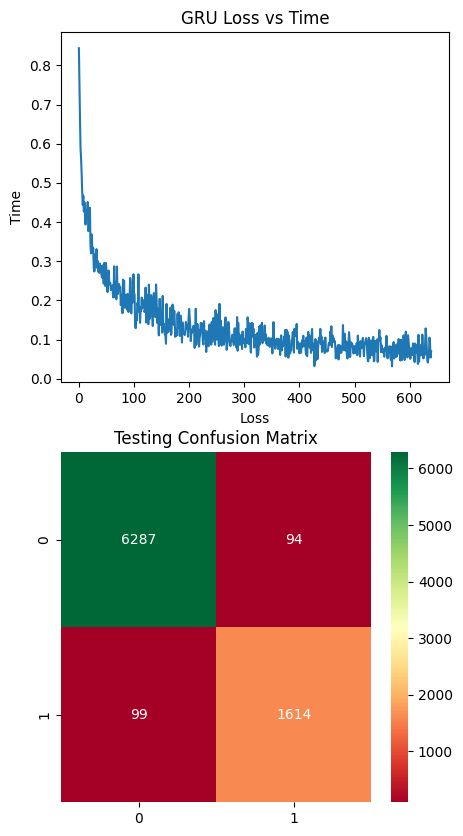

In [183]:
import torch.nn

#Hyperparameters
hidden_size = 10

class MyGRU(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #batch_first=True sets it so the order of input features is batch_size X sequence_length X num_features as we have prepared our dataset.
        self.gru = torch.nn.GRU(input_size=num_features, hidden_size=hidden_size, batch_first=True)

        #GRU output shape is batch_size X sequence_length X hidden_size, 
        #we flatten this into batch_size X (sequence_length * hidden_size) so we can pass it to our final layer
        self.flatten = torch.nn.Flatten()

        #For our linear layer, we use the one node binary classification method rather than the two node one to avoid converting to/from onehots. 
        #There is debate over this on the internet but consensus seems to indicate this does not significantly impact performance  
        self.linear = torch.nn.Linear(in_features=sequence_length*hidden_size, out_features=1)

        #Sigmoid since we're using Binary Cross Entropy which expects inputs between 0 and 1 and this is a binary classification task 
        self.sigmoid = torch.nn.Sigmoid()

    #As long as the tensor passes through the layers, the weights will be added for the gradient backprop
    def forward(self, X):
        #discarding the hidden values           Input Shapes:
        gru_out, _ = self.gru(X)                #batch_size X sequence_length X num_features
        flatten_out = self.flatten(gru_out)     #batch_size X sequence_length X hidden_size
        linear_out = self.linear(flatten_out)   #batch_size X (sequence_length * hidden_size)
        linear_out = torch.squeeze(linear_out)  #batch_size X 1
        sigmoid_out = self.sigmoid(linear_out)  #batch_size
        return sigmoid_out


my_GRU_model = MyGRU()
train_and_evaluate("GRU", my_GRU_model)

### Analysis 

The LSTM and the GRU preformed on average better than the raw RNN by around 5 to 10%. On a purely parameter-wise basis this makes sense as the LSTM has both long and short term memory, the GRU has a form of intelligent short term memory, and the RNN has unfiltered short term memory. It should be noted that when compared, the LSTM preforms significantly better than the GRU on the (harder) testing set, while they seem to preform the same on the (easy) validation set. The LSTM had on average a lot less false negatives than the GRU, presumably due to the LSTMs 3 gate structure with long term and short term memory, while the GRU doesn't have a mean of long term memory storage with its two gate update reset design. Even more interesting is that the GRU preforms worse than the RNN on this set. I hypothesize this is making it less able to deal with the chaotic nature of the test set which has many small bursts of room occupancy, while the training set and testing set have more periods of long room occupancy, the RNN isn't smart enough to pick up on this but the intelligent design of the GRU works against it under these circumstances. 

### Part 3 (10 points): Traditional Model
Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

### Response
Yes, a time series can be converted to features that can be used an input to a feed forward network, by ignoring the time component we can flatten a time series of shape `sequence_len X num_features` into a single `sequence_len * num_features` column vector which we can pass into a feed forward layer. Despite our ability to do this, it doesn't nessacarilly mean that we should, as we loose all of the context sensitive time data that RNNs are designed to improve performance on. The following is a feed forward model with ReLU activation on the hidden layer trained to preform the same task as the above RNNs. When this model does converge (which is rare) it has significantly lower performance than all of our RNN models and (normally) preforms significantly worse on the testing or validation set. 

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19

F1 Score for Training: 88.12%
F1 Score for Validation: 66.95%
F1 Score for Testing: 88.80%


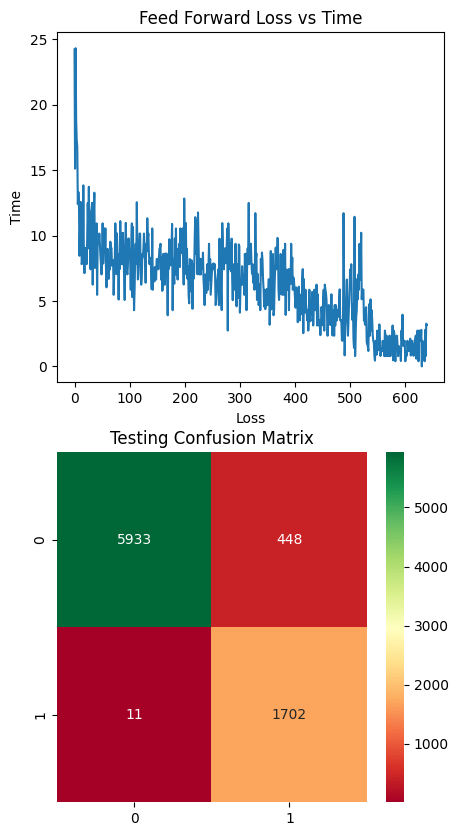

In [197]:
import torch.nn

#Hyperparameters
hidden_size = 10

class MyFeedForward(torch.nn.Module):
    def __init__(self):
        super().__init__()

        #since we're training it like a RNN, we still are taking in the matrix so have to flatten it first
        self.flatten = torch.nn.Flatten()

        #Takes the same input and output shape (flattened) as our RNNs did
        self.feed_forward = torch.nn.Linear(in_features=sequence_length*num_features, out_features=sequence_length*hidden_size)
        self.relu = torch.nn.ReLU()

        #For our linear layer, we use the one node binary classification method rather than the two node one to avoid converting to/from onehots. 
        #There is debate over this on the internet but consensus seems to indicate this does not significantly impact performance  
        self.linear = torch.nn.Linear(in_features=sequence_length*hidden_size, out_features=1)

        #Sigmoid since we're using Binary Cross Entropy which expects inputs between 0 and 1 and this is a binary classification task 
        self.sigmoid = torch.nn.Sigmoid()

    #As long as the tensor passes through the layers, the weights will be added for the gradient backprop
    def forward(self, X):
        flatten_out = self.flatten(X)                           #batch_size X sequence_length X num_features
        feed_forward_out = self.feed_forward(flatten_out)       #batch_size X (sequence_length * num_features)
        relu_out = self.relu(feed_forward_out)                  #batch_size X (sequence_length * hidden_size)
        linear_out = self.linear(relu_out)                      #batch_size X (sequence_length * hidden_size)
        linear_out = torch.squeeze(linear_out)                  #batch_size X 1
        sigmoid_out = self.sigmoid(linear_out)                  #batch_size
        return sigmoid_out


my_Feed_Forward_model = MyFeedForward()
train_and_evaluate("Feed Forward", my_Feed_Forward_model)

## Task 2 (25 points): Pre-trained word embeddings

In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link
provided with the lecture notes can be useful to get started. Write your own code/function that
uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of
words (read as user input). The dissimilarity score should be defined by you. You either can
have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In
either case clearly describe how this score helps determine the dissimilarity between 2 words.

### Setting up word2vec embeddings

The pre-trained word to vec embeddings I use are the smallest embeddings available trained on english wikipedia from the [WebVectors Project](http://vectors.nlpl.eu/explore/embeddings/en/models/). One key piece of information here is that this dataset appends the grammatical context the word is used in as part of the key, with an underscore after the word to denote grammatical context For example "computer" is passed as "computer_NOUN". Supposedly this helps learning for cases where a word can be multiple different types of grammatical constructs for example "crown_VERB" the act of making someone a king, and "crown_NOUN", the physical item that is a crown.  

In [208]:
import gensim.models

embeddings = gensim.models.KeyedVectors.load_word2vec_format("embedding/model.bin", binary=True)

In [215]:
#Testing out getting an embedding
embeddings["computer_NOUN"]

array([-0.336, -0.098, 0.192, 0.156, -0.381, 0.094, -0.008, 0.245, 0.298,
       -0.090, -0.299, 0.417, -0.230, 0.104, 0.073, 0.061, -0.631, -0.002,
       0.419, -0.190, -0.262, -0.286, 0.004, 0.077, 0.263, 0.094, -0.414,
       -0.295, 0.361, 0.279, -0.170, -0.170, -0.083, 0.312, -0.103,
       -0.561, -0.076, -0.297, -0.224, -0.458, -0.075, -0.198, -0.087,
       0.531, -0.226, -0.196, 0.010, -0.302, -0.123, 0.031, -0.145,
       -0.149, 0.143, 0.097, -0.036, 0.223, 0.312, 0.618, -0.027, -0.372,
       0.136, -0.306, 0.170, 0.097, -0.050, -0.118, 0.081, 0.417, 0.598,
       -0.255, -0.127, -0.125, -0.119, 0.218, 0.154, 0.017, -0.322, 0.211,
       -0.488, 0.278, 0.068, -0.292, -0.003, -0.011, -0.018, 0.404, 0.256,
       -0.286, 0.279, -0.202, 0.359, 0.348, 0.335, 0.228, -0.159, 0.171,
       -0.514, 0.099, 0.022, 0.163, 0.157, -0.214, -0.437, 0.041, 0.201,
       -0.555, 0.125, -0.252, 0.172, -0.035, -0.331, 0.269, 0.075, -0.228,
       0.113, -0.128, -0.424, -0.006, 0.005, 0.040, 

### Similarity and Dissimilarity
For similarity I implement cosine similarity as requested. Due to the nature of word embeddings, similar words being clustered together, an intuitive dissimilarity metric is measuring how far apart the word's vectors are in higher dimensional space. While Euclidean distance (L2 Distance) provides the shortest path through higher dimensional space, I think it would be more interesting to try the taxicab distance (L1 Distance) between the vectors. The taxicab distance is defined as the sum of the differences between individual components of the vector. I think this will give a more interesting dissimilarity metric than the euclidean distance since it will vary more greatly according to individual embedding dimensions. This may particularly be useful since in higher dimensions things on average have shorter euclidean distances due to the high dimensionality making it probabilistically likely that shorter paths exist. 

In [220]:
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def taxicab_dissimilarity(A, B):
     return np.sum(np.abs(A - B))


#Testing out some similarities and dissimilarities

words = [
    ["computer_NOUN", "workstation_NOUN"],  #Should be close
    ["crown_NOUN", "head_NOUN"],            #Crowns go on heads
    ["neptune_NOUN", "ocean_NOUN"],         #The planet probably offsets this 
    ["rock_NOUN", "fuzzy_ADJ"],             #Rocks typically are not fuzzy

]

for w1, w2 in words:
    sim = cosine_similarity(embeddings[w1], embeddings[w2])
    diff = taxicab_dissimilarity(embeddings[w1], embeddings[w2])
    print("Cosine Similarity between '{}' and '{}' is {:.02f}".format(w1, w2, sim))
    print("Taxicab Dissimilarity between '{}' and '{}' is {:.02f}".format(w1, w2, diff))

Cosine Similarity between 'computer_NOUN' and 'workstation_NOUN' is 0.56
Taxicab Dissimilarity between 'computer_NOUN' and 'workstation_NOUN' is 60.26
Cosine Similarity between 'crown_NOUN' and 'head_NOUN' is 0.23
Taxicab Dissimilarity between 'crown_NOUN' and 'head_NOUN' is 65.58
Cosine Similarity between 'neptune_NOUN' and 'ocean_NOUN' is 0.28
Taxicab Dissimilarity between 'neptune_NOUN' and 'ocean_NOUN' is 73.72
Cosine Similarity between 'rock_NOUN' and 'fuzzy_ADJ' is 0.15
Taxicab Dissimilarity between 'rock_NOUN' and 'fuzzy_ADJ' is 80.63


The results are pretty much what I expected. The two closest words are computer and workstation according to both the cosine similarity and taxicab dissimilarity, this makes sense as they are essentially synonyms. In the middle the two related concepts of crown and head and neptune and ocean, cosine similarity places a higher relationship between neptune and ocean, while taxicab dissimilarity places them the other way around. Finally both metrics agree that rock and fuzzy are very dissimilar, giving us our lowest cosine similarity and highest taxicab dissimilarity.  


Finally we get user input and print out the similarity and dissimilarity as requested by the assignment.

In [222]:
print("Please enter a word followed by and underscore and its part of grammar in all uppercase I.E: computer_NOUN, eat_VERB, fat_ADJ:")
w1 = input("Word 1 ==>")
w2 = input("Word 2 ==>")
sim = cosine_similarity(embeddings[w1], embeddings[w2])
diff = taxicab_dissimilarity(embeddings[w1], embeddings[w2])
print("Cosine Similarity between '{}' and '{}' is {:.02f}".format(w1, w2, sim))
print("Taxicab Dissimilarity between '{}' and '{}' is {:.02f}".format(w1, w2, diff))

Please enter a word followed by and underscore and its part of grammar in all uppercase I.E: computer_NOUN, eat_VERB, fat_ADJ:
Cosine Similarity between 'cute_ADJ' and 'dog_NOUN' is 0.40
Taxicab Dissimilarity between 'cute_ADJ' and 'dog_NOUN' is 59.73
